# old version

In [1]:
import os
import json
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # "0, 1" for multiple

import tensorflow as tf

In [3]:
INPUT_SHAPE = (512,256,3)
CLASS_NUMS = 4

In [4]:
def imread(path):
    im = cv2.imread(path)
    if im is None:
        return None
    
    im = im/255
    
    im_pad = np.zeros(INPUT_SHAPE,dtype=np.float64)
    h,w = im.shape[:2]
    if h/w > INPUT_SHAPE[0]/INPUT_SHAPE[1]:
        re_h = INPUT_SHAPE[0]
        re_w = int(w * (re_h / h))
    else:
        re_w = INPUT_SHAPE[1]
        re_h = int(h * (re_w / w))
    re_im = cv2.resize(im,(re_w,re_h))
    im_pad[:re_h,:re_w,:] = re_im.copy()
    return im_pad

In [5]:
def build_model(architecture='res50'):
    if architecture == 'res50':
        resnet_model = tf.keras.applications.resnet50.ResNet50(include_top=False,
                                weights='imagenet',input_shape=INPUT_SHAPE,pooling='avg')
        resnet_output = resnet_model.output

        resnet_input = resnet_model.input
#     elif architecture == 'res101':
#         resnet_input = tf.keras.Input((None,None,3))
#         _,_,_,_,C5 = resnet_graph(resnet_input,"resnet101")
#         resnet_output = tf.keras.layers.GlobalAveragePooling2D()(C5)

    output = tf.keras.layers.Dense(CLASS_NUMS,activation='softmax',name='fc_softmax')(resnet_output)

    sm_model = tf.keras.models.Model(inputs = resnet_input,outputs = output, name = 'res50_softmax')
    
    return sm_model

In [11]:
im_dir = '../dataset/bodytype/image_women/'
dataversion = 'v2'
train_json = '../dataset/bodytype/women_'+dataversion+'_train.json'
val_json = '../dataset/bodytype/women_'+dataversion+'_val.json'

In [12]:
if dataversion == 'v1':
    class_ids_dict = {0:u"Thin",1:u"Nomal",2:u"Fat",3:u"Fater"}
    model_path = './old_logs/20180801T1101_res50_momentum/ep_0094.h5'
if dataversion == 'v2':
    class_ids_dict = {0:u"yHourglass",1:u"yPear",2:u"yApple",3:u"yBanana"}
    model_path = './old_logs/20180902T1520_res50_adam_v2/ep_0020.h5'

In [13]:
f = open(train_json,'r')
train_infos = json.load(f)
f.close()
f = open(val_json,'r')
val_infos = json.load(f)
f.close()

In [14]:
architecture = 'res50'
model = build_model(architecture=architecture)
if model_path is not None:
    model.load_weights(model_path,by_name=True)

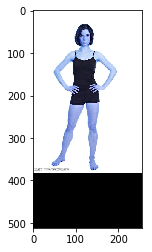

0 yHourglass
yHourglass 0.315711
yPear 0.3089312
yApple 0.17663372
yBanana 0.19872408


In [31]:
im = imread('../dataset/bodytype/test_im/4.jpg')
plt.imshow(im)
plt.show()
im = np.array([im])
res = model.predict(im)
ress = np.argmax(res)
print(ress,class_ids_dict[ress])
for i,con in enumerate(res[0]):
    print(class_ids_dict[i],con)

In [12]:
tr = 0
fa = 0
cur_infos = val_infos
for name in cur_infos.keys():
    im = imread(os.path.join(im_dir,name))
    if im is None:
        continue
    im = np.array([im])
    res = model.predict(im)
    res = np.argmax(res)
    if res == cur_infos[name]['label']:
        tr += 1
    else:
        fa += 1
print(tr,fa,tr/(fa+tr))

KeyboardInterrupt: 

# new version

In [1]:
import os
import json
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # "0, 1" for multiple

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
tf.keras.backend.set_session(session)

In [3]:
from model import Model
from config import Config

In [47]:
model_dir = './logs/regress_up_20181127T2244/'
model_path = os.path.join(model_dir,'ep_0020.h5')
config_path = os.path.join(model_dir,'config.json')
model_config = Config(mode='eval')
model_config.set_config(config_path)
model_config.set_param(["MODEL_PATH"],[model_path])
model_config.show_config()


======set config from file=======
./logs/regress_up_20181127T2244/config.json

set MODEL_PATH to ./logs/regress_up_20181127T2244/ep_0020.h5

============== Param =============
===========>config mode eval
ARCHITECTURE : res50
INPUT_SHAPE : [512, 256, 3]
MODEL_NAME : regress
CLASS_NUMS : 4
BETA_NUMS : 10
POSE_NUMS : 72
MODEL_PATH : ./logs/regress_up_20181127T2244/ep_0020.h5



In [48]:
im_dir = '../dataset/bodytype/up-3d-box/'
dataversion = 'up'
train_json = '../dataset/bodytype/dataset_'+dataversion+'_train.json'
val_json = '../dataset/bodytype/dataset_'+dataversion+'_val.json'

In [49]:
train_info = json.load(open(train_json,'r'))
val_info = json.load(open(val_json,'r'))

In [50]:
model = Model(model_config)

### eval by name

In [103]:
path = '../dataset/'

In [104]:
im,res = model.eval_one_image(path)
print(res)

[ 8.71131241e-01  5.84868908e-01 -1.49433434e-01 -7.64582455e-01
 -1.00392774e-01 -9.84462723e-03  7.87529722e-02  1.21740304e-01
  3.03561566e-04  7.80549925e-03]


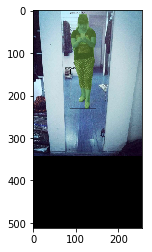

In [105]:
plt.imshow(im)
plt.show()

### eval by json

In [51]:
im_names = list(val_info.keys())

In [52]:
outputs = {}
json_outputs = {}
for i,name in enumerate(im_names):
    im_path = os.path.join(im_dir,name)
    im,res = model.eval_one_image(im_path)
    outputs[name] = {}
    outputs[name]['im'] = im
    outputs[name]['res'] = res
    json_outputs[name] = {}
    json_outputs[name]['betas'] = res.tolist()
    json_outputs[name]['pose'] = val_info[name]['pose']
    print(i+1,'/',len(im_names),end='\r')

In [53]:
output_json = os.path.join(model_dir,dataversion+'_val.json')
f = open(output_json,'w')
f.write(json.dumps(json_outputs,indent=2))

1964580

### eval by im_dir

In [8]:
im_names = os.listdir(im_dir)
outputs = model.eval_dir(im_dir)

### res analysis

---
pre need run eval by im_dir or json

#### one image analysis

In [ ]:
index = 0

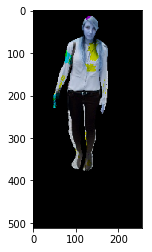

[[ 1.7027926   0.39060897 -0.14135121 -0.8588427  -0.02611794 -0.12069414
   0.05513055  0.04989207 -0.0231102   0.02935446]]
[1.275629922878907, 0.4650030728012351, -0.6264400497631449, -0.5889739344157363, 0.026416708658961133, -0.1001520167065878, -0.12271480256302841, 0.19046180573538105, 0.02373143940900977, -0.041180107217729564]

[-28.200042371377734, -0.7792637954683159, 1.6895729939838247, -0.36273618061380264, -0.07387172953913836, 0.01507266405651711, -0.07672151854801715, -0.06830093603354642, 0.008486241324850815, 0.216325078260019, 0.05004275790003645, -0.027408536308421313, 0.8713679010193871, -0.06872508454847419, -0.16284820407785425, 0.7521601757767516, 0.08383623941225292, 0.09597912703305335, -0.036595341533547834, 0.002237666619599755, -0.004186252027422904, 0.08849604916289115, 0.06794649053256367, -0.022128681580971355, -0.05984575321894413, -0.18793374786852346, 0.1110494907214463, 0.058339708051820746, -0.021280550569982782, -0.03560841235111531, -0.35774086263

In [20]:
name = im_names[index]
plt.imshow(outputs[name]['im'][0])
plt.show()
print(outputs[name]['res'][0])
print((train_info[name] or val_info[name])['betas'])
print()
print((train_info[name] or val_info[name])['pose'])

#### Mape

In [121]:
all_res = []
all_gt = []
for name in im_names:
    all_res.append(outputs[name]['res'])
    if name in train_info.keys():
        all_gt.append(train_info[name]['betas'])
    if name in val_info.keys():
        all_gt.append(val_info[name]['betas'])
import numpy as np
all_res = np.array(all_res)
all_gt = np.array(all_gt)
res = np.mean((np.abs(all_res-all_gt)/np.abs(all_gt))*100)
print(res)

451.6609027232511


#### Difference comparison

In [75]:
gt_info = val_info
pre_info = outputs

In [76]:
arr_1 = []
arr_2 = []
num = []
for i,name in enumerate(gt_info.keys()):
    arr_1.append(val_info[name]['betas'])
    arr_2.append(pre_info[name]['res'])
    num.append(i)
arr_1 = np.array(arr_1)
arr_2 = np.array(arr_2)
num = np.array(num)
dif = np.abs(arr_1-arr_2)

In [77]:
def statistics(x, name = "no name"):
    print(name,"mean",np.mean(x),"std",np.std(x),"max",np.max(x),"min",np.min(x))
    print(name,"ptp",np.ptp(x),"median",np.median(x),"average",np.average(x),"var",np.var(x))
    print()

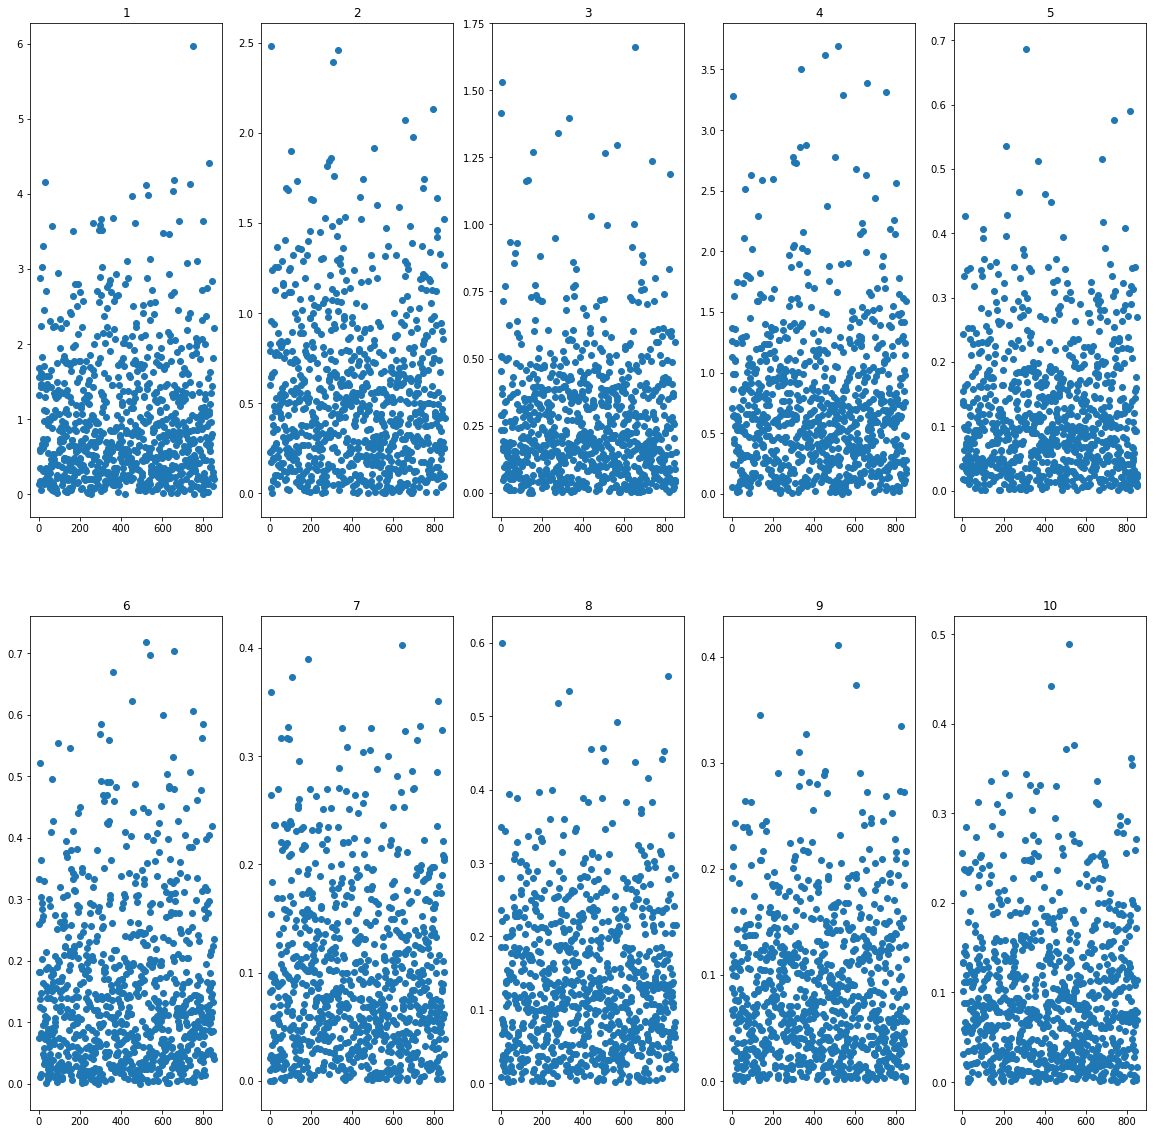

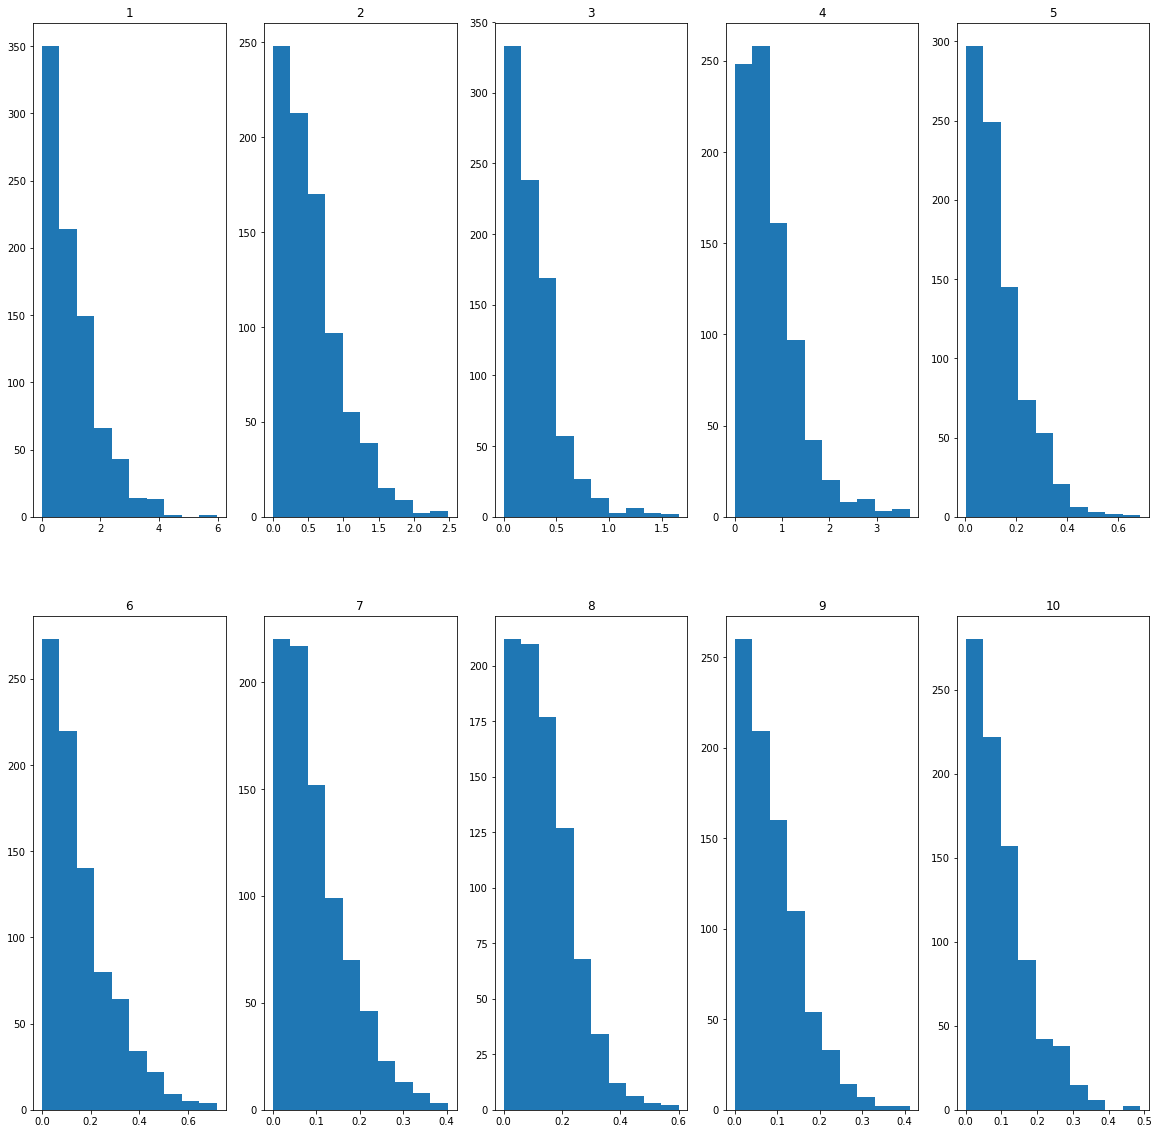

In [78]:
plt.figure(1,figsize=(20,20))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(i+1)
    plt.scatter(num,dif[:,i])
plt.show()
plt.figure(2,figsize=(20,20))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(i+1)
    plt.hist(dif[:,i])
plt.show()

In [79]:
for i in range(10):
    statistics(dif[:,i],str(i))

0 mean 1.0142202794251312 std 0.8755524676408981 max 5.97348363524378 min 0.003812009582956244
0 ptp 5.9696716256608235 median 0.7664781225499278 average 1.0142202794251312 var 0.766592123592066

1 mean 0.5396160100200251 std 0.4300053355403895 max 2.479895889271936 min 0.00041464590469730833
1 ptp 2.4794812433672386 median 0.4471888449023278 average 0.5396160100200251 var 0.18490458859320297

2 mean 0.2749102252362604 std 0.2362312836881937 max 1.661491771895638 min 0.0006949590505790637
2 ptp 1.6607968128450588 median 0.2143328640958108 average 0.2749102252362604 var 0.05580521939297185

3 mean 0.7517905328583128 std 0.6000812130032923 max 3.693974976382333 min 0.001684848518448634
3 ptp 3.6922901278638847 median 0.6293748182201049 average 0.7517905328583128 var 0.3600974621995027

4 mean 0.1250080486726859 std 0.10189059561731144 max 0.6863359565784162 min 0.0002065853944624163
4 ptp 0.6861293711839538 median 0.0982215161856008 average 0.1250080486726859 var 0.010381693475250486

5 

#### distributed

In [54]:
btmp = [[] for i in range(10)]
num = []
for i,key in enumerate(outputs):
    res = outputs[key]['res']
    for j in range(10):
        btmp[j].append(res[j])
    num.extend([i])

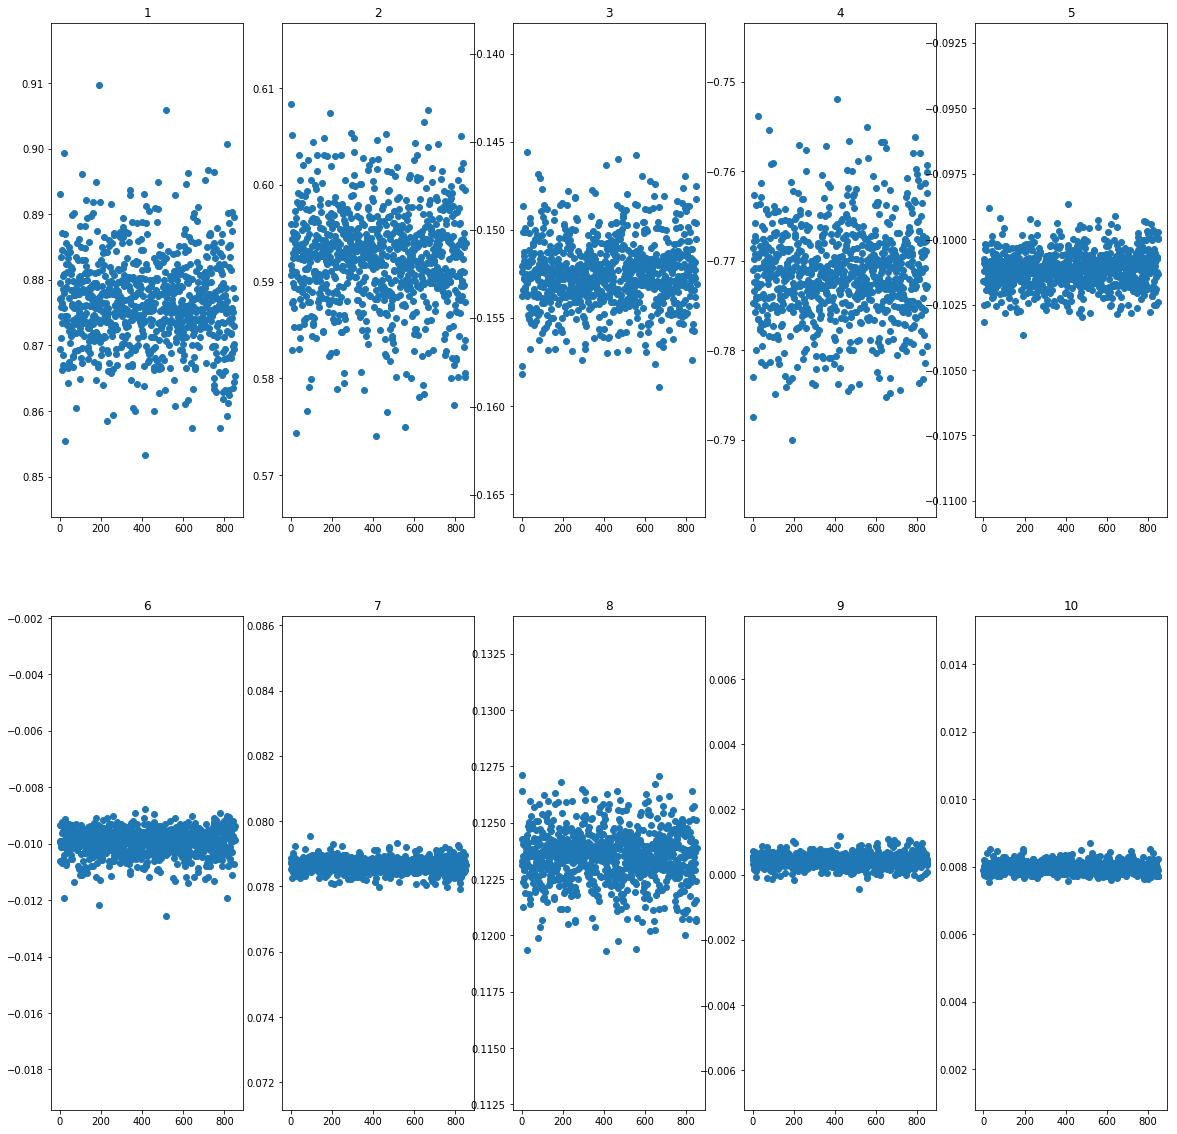

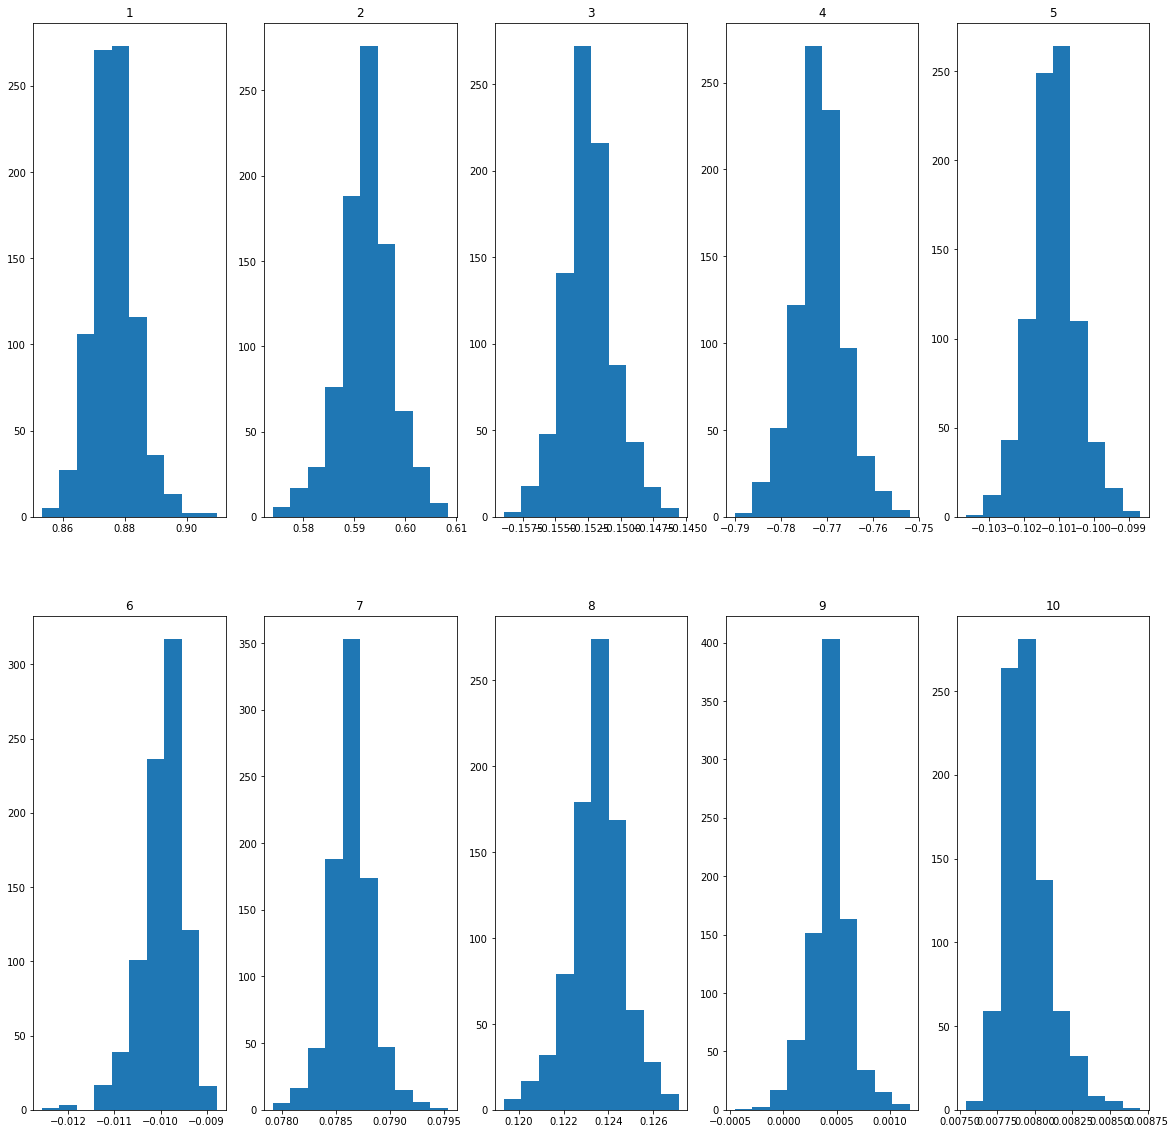

In [55]:
plt.figure(1,figsize=(20,20))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(i+1)
    plt.scatter(num,btmp[i])
plt.show()
plt.figure(2,figsize=(20,20))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(i+1)
    plt.hist(btmp[i])
plt.show()

In [56]:
def statistics(x, name = "no name"):
    print(name,"mean",np.mean(x),"std",np.std(x),"max",np.max(x),"min",np.min(x))
    print(name,"ptp",np.ptp(x),"median",np.median(x),"average",np.average(x),"var",np.var(x))
    print()

In [57]:
for i in range(10):
    statistics(btmp[i],str(i))

0 mean 0.8765658 std 0.006905355 max 0.9097448 min 0.85336006
0 ptp 0.056384742 median 0.8761459 average 0.8765658 var 4.7683927e-05

1 mean 0.59246653 std 0.005147272 max 0.6083669 min 0.5740789
1 ptp 0.03428799 median 0.59272987 average 0.59246653 var 2.6494408e-05

2 mean -0.15244567 std 0.0019129496 max -0.14557429 min -0.15894991
2 ptp 0.013375625 median -0.15252355 average -0.15244567 var 3.659376e-06

3 mean -0.7714201 std 0.005249687 max -0.751997 min -0.7900211
3 ptp 0.038024127 median -0.7714709 average -0.7714201 var 2.7559216e-05

4 mean -0.10115328 std 0.0006740276 max -0.09865781 min -0.103678346
4 ptp 0.0050205365 median -0.10115799 average -0.10115328 var 4.5431318e-07

5 mean -0.009943461 std 0.00045872474 max -0.008781165 min -0.012566242
5 ptp 0.0037850775 median -0.009888895 average -0.009943461 var 2.1042838e-07

6 mean 0.07864418 std 0.00019195967 max 0.07953777 min 0.077916354
6 ptp 0.0016214177 median 0.07864179 average 0.07864418 var 3.6848512e-08

7 mean 0.123